### Physics background:

To plot the eletric potential in a graph, some equations need to be accounted for.

Firstly, the eletric potential $V_E$ from a point-like object with charge $Q$ at a certain distance $r$ can be calculated with the following equation:
$$V_E = \frac{1}{4 \pi \varepsilon_0}\frac{Q}{r}$$ 
Where $\epsilon_0$ is the permittivity of vacuum, which is approximately $8.854187 \cdot 10^{-12}$

In [4]:
# Importing useful modules
import matplotlib.pyplot as plot;
import pandas as pd;
import numpy as np;

In [6]:
# Defining permitivitty of vaccum constant
eps_0 = 8.854187 * 10 ** -12;

In [7]:
# Function that gets position and potential data from a csv file.
def GetData(csvFile):
    data = pd.read_csv(csvFile);
    
    positions = data[['x', 'y']].values;
    eletricPotentials = data['V'].values;
    
    return positions, eletricPotentials;

In [8]:
# Function that calculates coeficient of a linear fit of *points.
def LinearFit(points):
    x = points[:, 0];
    y = points[:, 1];
    
    xAvg = np.sum(x) / len(x);
    yAvg = np.sum(y) / len(y);

    xyAvg   = np.sum(x * y) / len(x);
    xSqrAvg = np.sum(x * x) / len(x);

    # Calculates coeficients of linear function.
    a = (xyAvg - xAvg * yAvg) / (xSqrAvg - xAvg ** 2);
    b = (xSqrAvg * yAvg - xAvg * xyAvg) / (xSqrAvg - xAvg ** 2);
    
    return [a, b];

### Calculating charge:

Considering a system with $n$ charged point-like objects, the eletric potential $V_E$ in a point $p$ can be calculated with the sum of the individual potentials between each charged point $p_i$ and $p$.
$$V_E = \sum_{i = 0}^n V_i$$
Using the equation in *Physics background*:
$$V_E = \frac{1}{4 \pi \varepsilon_0} \sum_{i = 0}^{n} \frac{Q_i}{r_i}$$
Where:
$$r_i = |p - p_i|$$
Each charge $Q_i$ can be represented as:
$$Q_i = Qk_i$$
Then:
$$V_E = \frac{1}{4 \pi \varepsilon_0} \sum_{i = 0}^{n} \frac{k_iQ}{r_i}$$
$$V_E = \frac{Q}{4 \pi \varepsilon_0} \sum_{i = 0}^{n} \frac{k_i}{r_i}$$
The charge $Q$ of the point-like object is unknown, but rearranging the expression of the eletric potential, its possible to calculate the charge $Q$, and then the charge of the object $k_iQ$. This method is useful when the proportionality of the charges is known. For example, in a circuit, there are two eletrodes with opposite charges $(k_1 = 1, k_2 = -2)$
$$Q = V_E \cdot 4 \pi \varepsilon_0 \left(\sum_{i = 0}^{n} \frac{k_i}{r_i}\right)^{-1}$$
Therefore, the charge of the object can be calculated by only measuring the eletric potential $V_E$, the distances from each charged points $r_i$ and by knowing the proportions between each object charge $k_i$.

Then, with many measurements of points and eletric potentials, it is possible to calculate an average value for the charge $Q$:
$$\bar Q = \frac {4 \pi \varepsilon_0}{N} \sum_{j = 0}^{N} V_{j} \cdot \left(\sum_{i = 0}^{n} \frac{k_i}{r_i}\right)^{-1}$$
Where $N$ is the number of points, $n$ is the number of charged point-like objects, $V_j$ is the eletric potential measured in a point $j$, $r_i$ is the distance from that point to a charged object and $k_i$ is the charge proportion of the point-like object $i$.

In [9]:
# Calculates average value of the charge of the point-like object in couloumbs.
def CalculateCharge(chargedPoints, points, eletricPotentials, k):
    chargedSum = 0;

    numPoints = len(points);
    for i, point in enumerate(points):
        distanceSum = 0;
        for j, chargedPoint in enumerate(chargedPoints):
            distanceVector = (point - chargedPoint) * 10 ** -2;
            r = np.linalg.norm(distanceVector);

            distanceSum += k[j] / r;

        if (distanceSum == 0): numPoints -= 1; continue;
        chargedSum += eletricPotentials[i] / distanceSum;

    return chargedSum * 4 * np.pi * eps_0 / len(points);

In [10]:
# Setting charge of point-like objects in the system.
chargedPoints = np.array([[-15, 0], [15, 0]]); # Points with eletric current
k = [-1, 1]; # Constants of proportionality

measuredPoints, measuredPotentials = GetData("dados1.csv");
charge = CalculateCharge(chargedPoints, measuredPoints, measuredPotentials, k);
#charge  = CalculateCharge(chargedPoints[0], [[-9.8, 0]], [10], k);

charges = [ charge, -charge ]; # Positive and negative charges.

# Setting range where potential will be calculated.
start, end = -25, 25;
numPoints = 100;

In [11]:
# Calculates the eletric potential of a *point, considering *chargedPoints and *charges.
def CalculatePotential(point, chargedPoints, charges):
    potential = 0;
    for i, chargedPoint in enumerate(chargedPoints):
        distanceVector = (point - chargedPoint) * 10 ** -2;
        r = np.linalg.norm(distanceVector);
        if (r == 0): potential = None; continue;
        
        potential += 1 / (4 * np.pi * eps_0) * charges[i] / r;

    return potential;

# Calculates the eletric potential of many points between start and end. The z-axis is the potential.
def CalculatePotentialPoints(start, end, size, chargedPoints, charges):
    meshSpace = np.linspace(start, end, size);
    
    zPoints = [];
    for xPoint in meshSpace:
        curX = [];
        for yPoint in meshSpace:
            curX.append(CalculatePotential(np.array([xPoint, yPoint]), chargedPoints, charges));
            
        zPoints.append(np.array(curX));

    x, y = np.meshgrid(meshSpace, meshSpace);
    z = np.array(zPoints);

    return x, y, z;

In [67]:
# Plots 3D graph and its contour graph. Returns 3D subplot and contour axis subplot.
def Plot3D(x, y, z, numLevels, xlabel="x", ylabel="y", title=""):
    fig = plot.figure(figsize=(10, 4)); 

    #plot.contour(y, x, z, numLevels, cmap="Set2", zorder=0);
    #plot.colorbar();
    ax2D = fig.add_subplot(1, 2, 1);
    ax2D.contour(y, x, z, numLevels, cmap="Set2", zorder=0);

    plot.title(title);
    plot.xlabel(xlabel);
    plot.ylabel(ylabel);
    
    ax = fig.add_subplot(1, 2, 2, projection='3d');
    ax.contour3D(y, x, z, 70, cmap="Set2", linestyles='solid', levels=numLevels);
    
    plot.xlabel(xlabel);
    plot.ylabel(ylabel);
    plot.title(title + " (3D)");

    return ax, ax2D, fig;

### Plotting equipotential lines:

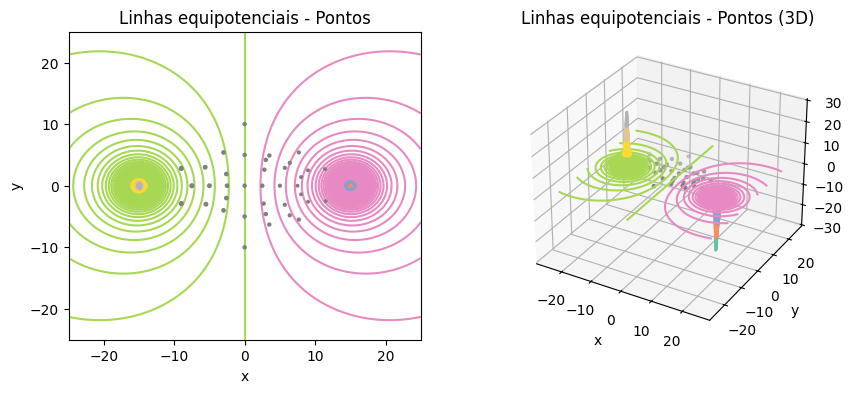

In [69]:
x, y, z = CalculatePotentialPoints(start, end, numPoints, chargedPoints, charges); 

ax, ax2D, fig = Plot3D(x, y, z, 400, title="Linhas equipotenciais - Pontos");
scatteredPoints, scatteredPotentials = GetData("dados1.csv");

ax.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1, marker='.');
ax2D.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1);

fig.savefig("Plot1.png");

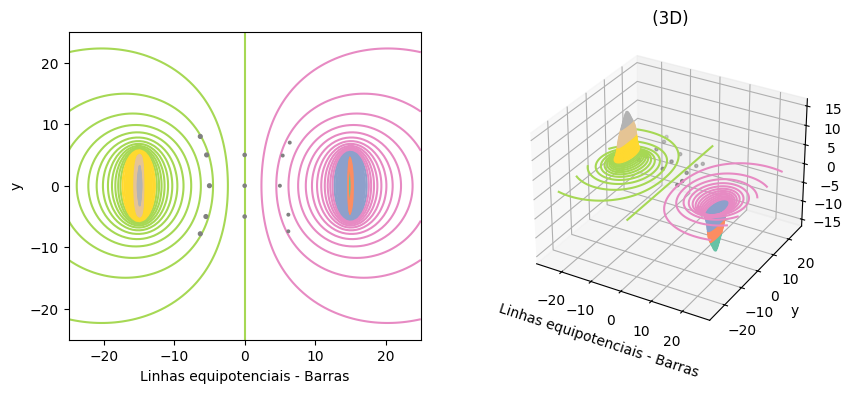

In [71]:
# Calculating charge along two metal bars.
barPositions = chargedPoints;
graphSize = end - start;
barSize = 10;

eletricDensity = charge / barSize; # Calculating eletric density in each bar.

barYPoints = np.linspace(-barSize / 2, barSize / 2, int(barSize / graphSize * numPoints));
barXPoints = np.zeros(len(barYPoints));

barPoints = np.column_stack((barXPoints, barYPoints));

locatedChargesList= [];
for barPos in barPositions: 
    locatedChargesList += (barPoints + barPos).tolist();

locatedChargePoints = np.array(locatedChargesList);

barCharges = np.zeros(len(barPoints) * len(barPositions));
barCharges.fill(eletricDensity);
barCharges[int(len(barCharges) / 2):] *= -1; # Half with negative charge

x, y, z = CalculatePotentialPoints(start, end, numPoints, locatedChargePoints, barCharges); 

scatteredPoints, scatteredPotentials = GetData("dados2.csv");
ax, ax2D, fig = Plot3D(x, y, z, 100, title="Linhas equipotenciais - Barras");

ax.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1, marker='.');
ax2D.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1);

fig.savefig("Plot2.png");

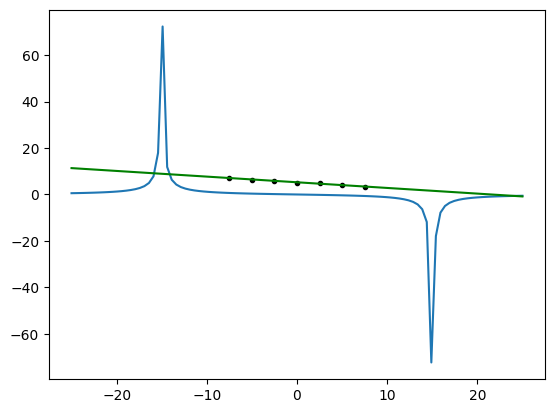

In [118]:
xValues = np.linspace(start, end, numPoints);

analiticList = [];
for x in xValues:
    analiticList.append(CalculatePotential([x, 0], chargedPoints, charges));

analiticPotentials = np.array(analiticList);

xAxisPotentials = [];
xAxisPoints = [];

# Filtering measured points where y = 0.
for i, point in enumerate(measuredPoints): 
    if (point[1] != 0): continue;
    xAxisPoints.append(point[0]);
    xAxisPotentials.append(measuredPotentials[i]);

xAxisPoints = np.array(xAxisPoints);
xAxisPotentials = np.array(xAxisPotentials);

plot.plot(xValues, analiticPotentials);

a, b = LinearFit(np.column_stack((xAxisPoints, xAxisPotentials)));
plot.scatter(xAxisPoints, xAxisPotentials, c='k', marker='.');
plot.plot(xValues, a * xValues + b, c='g');

### Calculating Field:

In [41]:
# Calculates eletric field of an array of point-like objects considering *chargedPoints and *charges.
def CalculateField(point, chargedPoints, charges):
    eletricField = np.zeros(2);
    for i, chargedPoint in enumerate(chargedPoints):
        distanceVector = (point - chargedPoint) * 10 ** -2;
        r = np.linalg.norm(distanceVector);
        if (r == 0): eletricField = None; continue;

        direction = distanceVector / r;
        
        eletricField += charges[i] / r ** 2 * direction;

    return 1 / (4 * np.pi * eps_0) * eletricField;

In [106]:
eletricFieldPoints = np.array([[-5, 0], [0, 0], [5, 0]]); # Points to calculate eletric field.

for point in eletricFieldPoints: 
    print(CalculateField(point, chargedPoints, charges));

print(CalculateField([5, 5], chargedPoints, charges));

[9.1715015 0.       ]
[6.52195662 0.        ]
[9.1715015 0.       ]
[ 6.9249281  -2.20632333]
